In [57]:
import zipfile
import os

with zipfile.ZipFile("/content/archive (3).zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

os.listdir("/content/dataset")


['Intent.json']

In [58]:
with open("/content/dataset/Intent.json") as file:
    data = json.load(file)

print("Number of intent categories:", len(data['intents']))
print("\nExample of an intent:\n")
print(json.dumps(data['intents'][0], indent=2))


Number of intent categories: 22

Example of an intent:

{
  "intent": "Greeting",
  "text": [
    "Hi",
    "Hi there",
    "Hola",
    "Hello",
    "Hello there",
    "Hya",
    "Hya there"
  ],
  "responses": [
    "Hi human, please tell me your GeniSys user",
    "Hello human, please tell me your GeniSys user",
    "Hola human, please tell me your GeniSys user"
  ],
  "extension": {
    "function": "",
    "entities": false,
    "responses": []
  },
  "context": {
    "in": "",
    "out": "GreetingUserRequest",
    "clear": false
  },
  "entityType": "NA",
  "entities": []
}


In [59]:
rows = []

for intent in data['intents']:
    tag = intent['intent'] if 'intent' in intent else intent['tag']
    for pattern in intent['text'] if 'text' in intent else intent['patterns']:
        rows.append({"text": pattern, "label": tag})

import pandas as pd

df = pd.DataFrame(rows)
print("Dataset size:", df.shape)
df.head()


Dataset size: (143, 2)


,text,label
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


In [60]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


Train size: (114,)
Test size: (29,)


In [61]:
# Train Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train_vec, y_train)

y_pred = log_reg.predict(X_test_vec)

print("✅ Logistic Regression Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Logistic Regression Model Performance:
Accuracy: 0.6896551724137931

Classification Report:
                           precision    recall  f1-score   support

                  Clever       1.00      1.00      1.00         1
         CourtesyGoodBye       0.50      1.00      0.67         1
        CourtesyGreeting       1.00      1.00      1.00         1
CourtesyGreetingResponse       0.67      1.00      0.80         2
       CurrentHumanQuery       0.00      0.00      0.00         2
                 GoodBye       0.00      0.00      0.00         1
                  Gossip       1.00      1.00      1.00         1
                Greeting       0.33      1.00      0.50         1
        GreetingResponse       1.00      0.50      0.67         2
                   Jokes       1.00      1.00      1.00         1
               NameQuery       0.00      0.00      0.00         1
            NotTalking2U       1.00      1.00      1.00         2
              PodBayDoor       0.50      1.00 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The class to report if `average='binary'` and the data is binary,
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The class to report if `average='binary'` and the data is binary,
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The class to report if `average='binary'` and the data is binary,


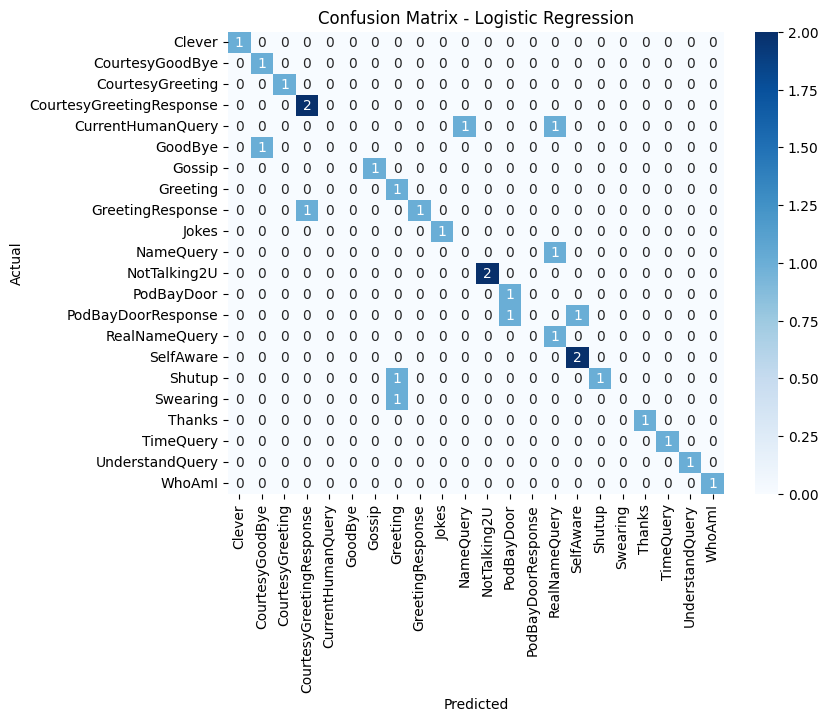

In [62]:
#CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=log_reg.classes_,
            yticklabels=log_reg.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [63]:
#Deep learning Model (ANN)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_vec.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(y_train.unique()), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

history = model.fit(X_train_vec.toarray(), y_train_enc,
                    epochs=20, batch_size=8,
                    validation_data=(X_test_vec.toarray(), y_test_enc),
                    verbose=1)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0409 - loss: 3.0982 - val_accuracy: 0.0690 - val_loss: 3.0723
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2182 - loss: 3.0411 - val_accuracy: 0.2759 - val_loss: 3.0399
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4331 - loss: 2.9824 - val_accuracy: 0.3448 - val_loss: 2.9999
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3982 - loss: 2.9321 - val_accuracy: 0.3103 - val_loss: 2.9547
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5131 - loss: 2.8524 - val_accuracy: 0.3448 - val_loss: 2.8970
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6293 - loss: 2.7700 - val_accuracy: 0.5172 - val_loss: 2.8122
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5987 - loss: 2.6664 - val_accuracy: 0.5517 - val_loss: 2.7107
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7080 - loss: 2.4543 - val_accuracy: 0.5862 - val_loss: 2.5832
Ep

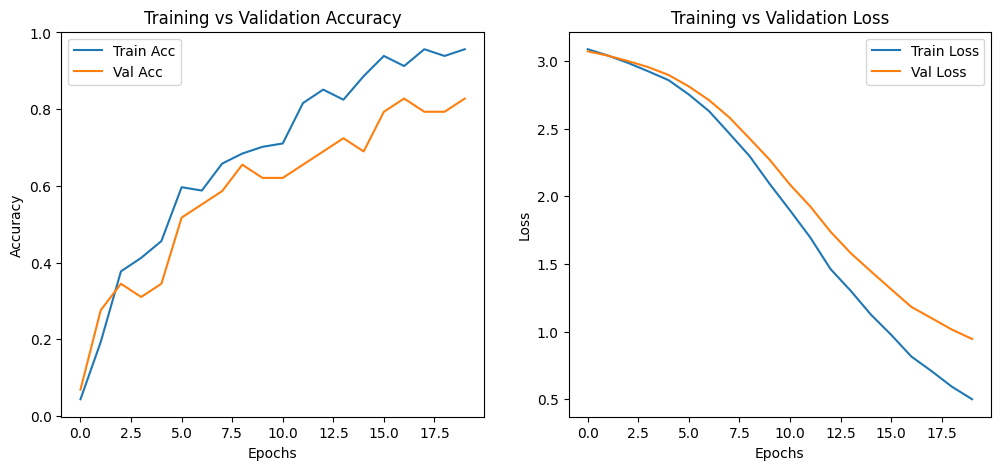

In [64]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [65]:
#Evaluate ANN Model

y_pred_dl = model.predict(X_test_vec.toarray())
y_pred_labels = np.argmax(y_pred_dl, axis=1)

print("\n✅ ANN Model Performance:")
print("Accuracy:", accuracy_score(y_test_enc, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred_labels, target_names=le.classes_))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

✅ ANN Model Performance:
Accuracy: 0.8275862068965517

Classification Report:
                           precision    recall  f1-score   support

                  Clever       1.00      1.00      1.00         1
         CourtesyGoodBye       0.50      1.00      0.67         1
        CourtesyGreeting       1.00      1.00      1.00         1
CourtesyGreetingResponse       1.00      1.00      1.00         2
       CurrentHumanQuery       1.00      0.50      0.67         2
                 GoodBye       0.00      0.00      0.00         1
                  Gossip       1.00      1.00      1.00         1
                Greeting       1.00      1.00      1.00         1
        GreetingResponse       1.00      1.00      1.00         2
                   Jokes       1.00      1.00      1.00         1
               NameQuery       0.00      0.00      0.00         1
            NotTalking2U       1.00      1.00      1.00         2
              PodBayDoo

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The class to report if `average='binary'` and the data is binary,
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The class to report if `average='binary'` and the data is binary,
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The class to report if `average='binary'` and the data is binary,


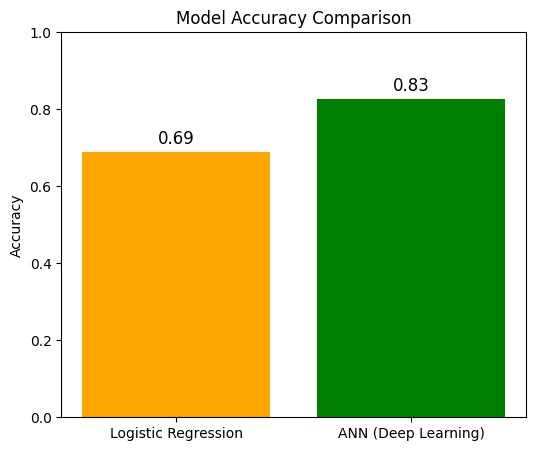

In [66]:
# Compare Model Accuracies

models = ['Logistic Regression', 'ANN (Deep Learning)']
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test_enc, y_pred_labels)
]

plt.figure(figsize=(6,5))
plt.bar(models, accuracies, color=['orange', 'green'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
plt.show()


In [68]:
def predict_intent(text):
    cleaned = clean_text(text)
    vector = vectorizer.transform([cleaned])

    prediction = model.predict(vector.toarray())
    label_index = np.argmax(prediction)
    intent = le.classes_[label_index]

    return intent

while True:
    user_input = input("You: ")
    if user_input.lower() in ["quit", "exit", "bye"]:
        print("Bot: Goodbye! 👋")
        break
    intent = predict_intent(user_input)
    print(f"Predicted Intent: {intent}")


You: hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Intent: Greeting
You: hola
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Intent: Greeting
You: How are you?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Intent: CourtesyGreeting
You: bye
Bot: Goodbye! 👋
